In [2]:
from sklearn.model_selection import train_test_split

def get_collection(client, name):
    return pd.DataFrame(client['Houses'][name].find({})).drop(['_id', 'url','description'], axis=1)
def convert_price_to_tnd(df, price_column='price', eur_to_tnd=3.34):
    h = df.copy()
    h[price_column] = (
        h[price_column]
        .str.extract(r'(\d[\d\s]*)')[0]
        .str.replace(r'\s+', '', regex=True).str.replace(',','',regex=True)
        .astype(float)
        * h[price_column].apply(lambda x: eur_to_tnd if 'EUR' in x else 1)
    )
    h = h.reset_index(drop=True)
    return h.copy()



In [3]:
import pandas as pd
import pymongo
import seaborn as sns
import warnings
import os
import matplotlib.pyplot as plt
from dotenv import load_dotenv



load_dotenv(dotenv_path='secret.env')  # Contains MongoDB URI

warnings.filterwarnings('ignore')

mongodb_uri = os.getenv('MONGODB_URI')
client = pymongo.MongoClient(mongodb_uri)

In [4]:
affare = get_collection(client, 'Affare')

In [169]:
affare['Type'].value_counts()

Type
Vente - Maisons            8274
Terrains & Fermes          8188
Location - Appartements    4533
Vente - Appartements       3987
Location - Maisons         2280
Location de vacances       1907
Commerces & Bureaux        1656
Autre Immobilier            341
Colocations                  19
Name: count, dtype: int64

In [5]:
affare_df = affare[affare['price'].isna() == False].copy()
affare_df = convert_price_to_tnd(affare_df, 'price')
affare_df.drop(['Meublée', 'posting_date', 'Adresse'], axis=1, inplace=True)
affare_df['Chambre'] = affare_df['Chambre'].str.extract('(\d+)').astype(float)
affare_df['Salles de bains'] = affare_df['Salles de bains'].str.extract('(\d+)').astype(float)
affare_df['Superficie'] = affare_df['Superficie'].str.extract('(\d+)').astype(float)
affare_df['city'] = affare_df['location'].str.split(' - ', expand=True).loc[:, 1].str.lower().str.replace('é', 'e').str.replace('è','e').str.replace('à','a').apply(lambda x : 'djerba' if 'djerba' in x else x)
affare_df['state'] = affare_df['location'].str.split(' - ', expand=True).loc[:, 0].str.lower().str.replace('é', 'e').str.replace('è','e').str.replace('à','a')
affare_df = affare_df[(affare_df['Type'] == 'Vente - Appartements') | (affare_df['Type'] == 'Vente - Maisons') | (affare_df['Type'] == 'Terrains & Fermes')]

affare_df['Type'] = affare_df['Type'].map({'Vente - Appartements':'appartement','Vente - Maisons':'villa','Terrains & Fermes':'terrain'})
affare_df.rename(
    {"Chambre": 'n_bedrooms',
    'Salles de bains': 'n_bathrooms',
    'Superficie': 'area'}
    , axis='columns', inplace=True)
affare_df.loc[affare_df['Type'] == 'terrain', ['n_bedrooms', 'n_bathrooms']] = affare_df.loc[affare_df['Type'] == 'terrain', ['n_bedrooms', 'n_bathrooms']].fillna(0)



df = affare_df.copy()


In [6]:
menzili = get_collection(client, 'menzili')
menzili['price'] = menzili['price'].str.replace(' ', '').str.extract('(\d+)').astype('Int64')
menzili.dropna(subset=['Surf terrain', 'Salle de bain', 'Chambres', 'price', 'location'],inplace=True)
menzili.drop(['Piéces Totale', 'Année construction', 'Surf habitable', 'misc'], axis=1, inplace=True)
menzili.rename({'Chambres': 'n_bedrooms', 'Salle de bain': 'n_bathrooms', 'Surf terrain': 'area'}, axis='columns', inplace=True)
menzili['n_bedrooms'] = menzili['n_bedrooms'].str.replace('+', '').astype('Int64')
menzili['n_bathrooms'] = menzili['n_bathrooms'].str.replace('+', '').astype('Int64')
menzili['area'] = menzili['area'].str.extract('(\d+)').astype('Int64')
menzili['state'] = menzili['location'].str.split(', ', expand=True).loc[:, 2].str.lower().str.replace('é', 'e').str.replace('è','e').str.replace('à','a')
menzili['city'] = menzili['location'].str.split(', ', expand=True).loc[:, 1].str.lower().str.replace('é', 'e').str.replace('è','e').str.replace('à','a')

menzili.dropna(subset=['city', 'state'], inplace=True)
menzili['city'] = menzili['city'].str.replace('djerba - midoun', 'djerba')
menzili['city'] = menzili['city'].apply(lambda x : 'djerba' if 'djerba' in x else x)

In [7]:
FEATURES = ['n_bedrooms','n_bathrooms','area','price','title','Type','city','state']
agg = pd.concat([menzili[FEATURES],df[FEATURES]],axis=0).reset_index(drop=True)

In [8]:
agg.drop_duplicates(subset=['title'],inplace=True)

<h4>Data Integrity Check & Cleaning

It is common for online marketplaces to contain data entry errors as can be seen below in the price description. It is important for us to consider a representative and realistic range of prices within which we attempt to build a model. A preliminary lower and upper bound of 60,000 TND and 2,000,000 TND respectively would be appropriate.

In [9]:
agg.groupby('Type')['price'].describe().T

Type,appartement,terrain,villa
count,3730.0,3415.0,8636.0
mean,844799.404021,34657931.203514,4335711.058592
std,12187706.946448,1902192833.650738,73135503.860812
min,1.0,1.0,1.0
25%,175000.0,78000.0,360000.0
50%,279000.0,240000.0,770000.0
75%,414250.0,528000.0,1100000.0
max,520000000.0,111111111111.0,3000000000.0


In [10]:
agg = agg[
    ((agg['Type'] == 'appartement') & (agg['price'] >= 70000)) |
    ((agg['Type'] == 'villa') & (agg['price'] >= 70000)) | ((agg['Type'] == 'terrain') & (agg['price'] >= 60000))
]
agg.groupby('Type')['price'].describe(percentiles=[.25, .5, .75, .90]).T


Type,appartement,terrain,villa
count,3388.0,2663.0,7948.0
mean,929605.461629,44440676.768306,4710758.064796
std,12785165.707494,2154080496.376215,76224017.529968
min,70000.0,60000.0,70000.0
25%,200000.0,175500.0,470000.0
50%,300000.0,340000.0,800000.0
75%,435000.0,651000.0,1180000.0
90%,660000.0,1321680.0,1700000.0
max,520000000.0,111111111111.0,3000000000.0


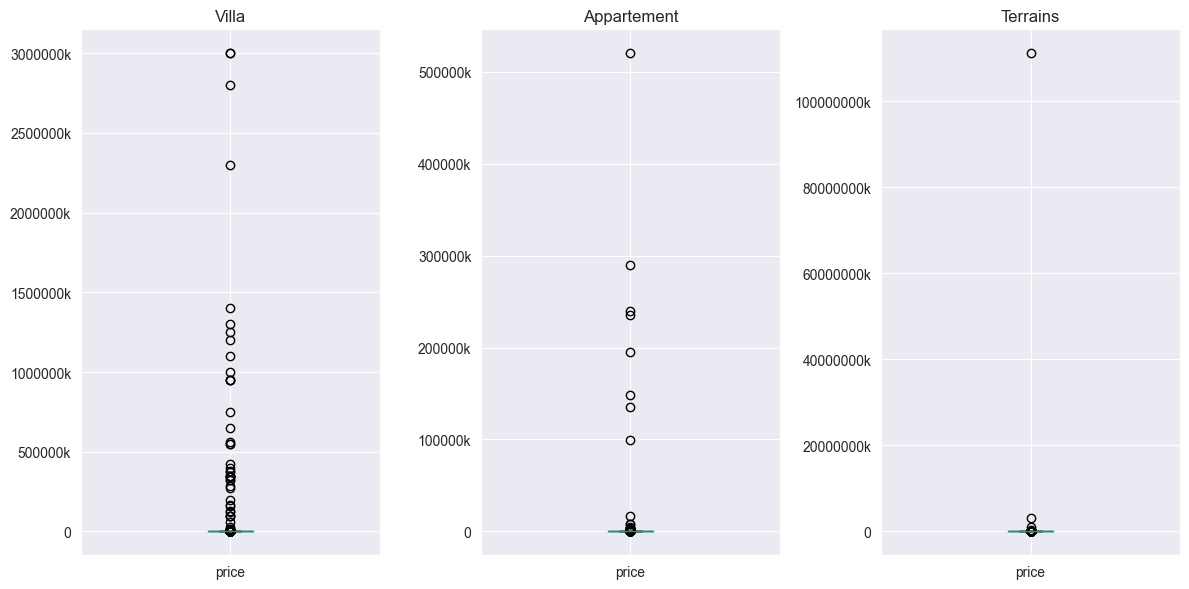

In [11]:
from matplotlib.ticker import FuncFormatter #for number formatting on the graph
def y_formatter(x, pos):
    if x >= 1000:
        return f'{int(x / 1000)}k'
    return str(int(x))

fig, axes = plt.subplots(1, 3, figsize=(12, 6))
agg[agg['Type'] == 'villa'].boxplot(column='price', ax=axes[0])
agg[agg['Type'] == 'appartement'].boxplot(column='price', ax=axes[1])
agg[agg['Type'] == 'terrain'].boxplot(column='price', ax=axes[2])
axes[0].set_title('Villa')
axes[1].set_title('Appartement')
axes[2].set_title('Terrains')

for ax in axes:
    ax.yaxis.set_major_formatter(FuncFormatter(y_formatter))
plt.tight_layout()
plt.show()

As we can observe, 90% of the villa postings have a price lower than 1,600,000 TND and 90% of appartment postings are listed lower than 640,000 TND.

Drawing on our knowledge of the housing market in Tunisia and by referring to dedicated market analysis reports, we will only consider:

villa prices in the range (60,000 ; 1,600,000)

Apartment prices in the range (60,000; 650,000)

With the higher end of these intervals likely representing luxurious postings


In [12]:
agg = agg[
    ((agg['Type'] == 'appartement') & (agg['price'] <= 600000)) |
    ((agg['Type'] == 'villa') & (agg['price'] <= 1000000)) | ((agg['Type'] == 'terrain') & (agg['price'] <= 700000))
]

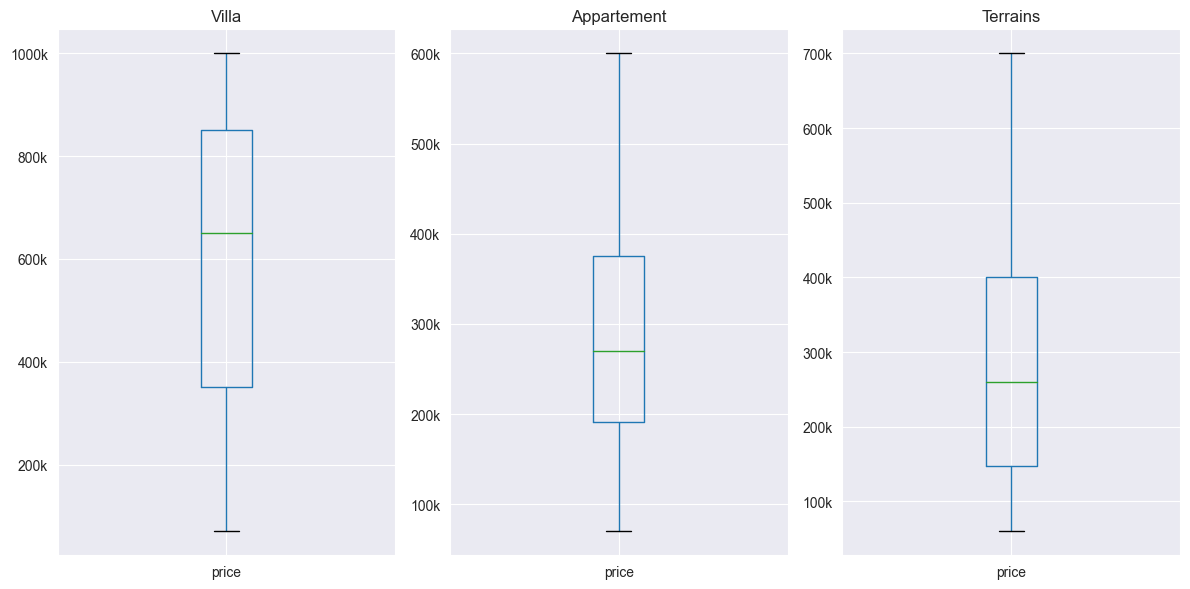

In [13]:
from matplotlib.ticker import FuncFormatter #for number formatting on the graph
def y_formatter(x, pos):
    if x >= 1000:
        return f'{int(x / 1000)}k'
    return str(int(x))

fig, axes = plt.subplots(1, 3, figsize=(12, 6))
agg[agg['Type'] == 'villa'].boxplot(column='price', ax=axes[0])
agg[agg['Type'] == 'appartement'].boxplot(column='price', ax=axes[1])
agg[agg['Type'] == 'terrain'].boxplot(column='price', ax=axes[2])
axes[0].set_title('Villa')
axes[1].set_title('Appartement')

axes[2].set_title('Terrains')
for ax in axes:
    ax.yaxis.set_major_formatter(FuncFormatter(y_formatter))
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Terrains price distribution')

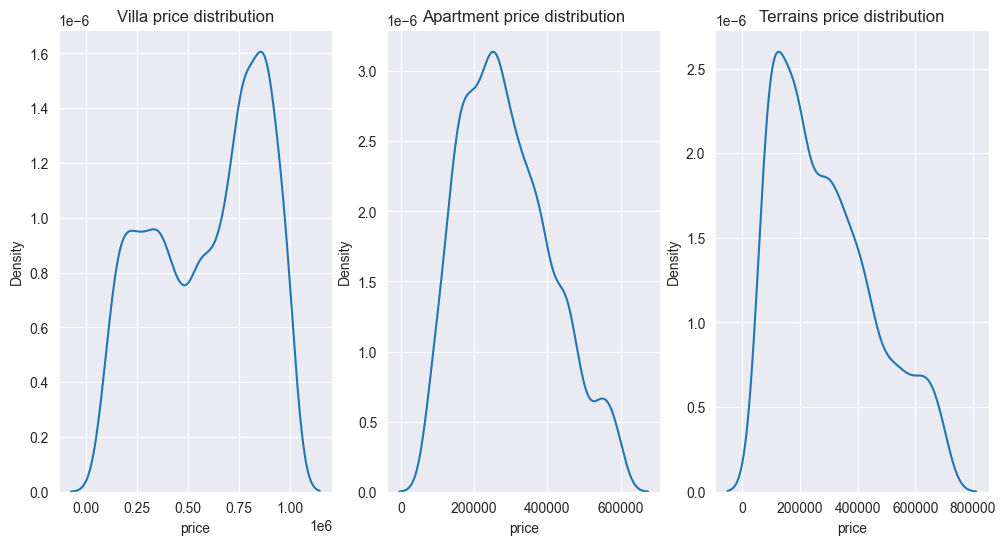

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(12, 6))
sns.kdeplot(agg[agg['Type'] == 'villa']['price'], ax=axes[0])
sns.kdeplot(agg[agg['Type'] == 'appartement']['price'], ax=axes[1])
sns.kdeplot(agg[agg['Type'] == 'terrain']['price'], ax=axes[2])

axes[0].set_title('Villa price distribution')
axes[1].set_title('Apartment price distribution')
axes[2].set_title('Terrains price distribution')

Price distributions for villa and apartment prices are approximately normal. Moving on to 'Area' (lot size) feature.

Similar data entry issues to the price feature exist. As per "https://unhabitat.org/sites/default/files/documents/2019-07/tunisia_urban_housing_sector_profile.pdf"

Villa housing is now the fastest growing type of
housing in Tunisia. It can be both formal and informal
and usually found on fringe and peri-urban locations.
Formal villa housing has lot sizes that normally vary
from 300 to 900 m², although in peri-urban locations
lot sizes can be much bigger.

Average apartment lot sizes start off from 25 m²

In [15]:
agg.groupby('Type')['area'].describe(percentiles=[0.25,.5,.75,.9,.95]).T

Type,appartement,terrain,villa
count,2717.0,1900.0,5406.0
mean,733.409275,10448.298947,744.809286
std,24962.165494,88601.988317,15093.016786
min,0.0,2.0,0.0
25%,85.0,370.0,210.0
50%,110.0,643.5,300.0
75%,140.0,2671.75,450.0
90%,172.0,10000.0,600.0
95%,206.2,30050.0,957.0
max,1266666.0,2500000.0,900000.0


In [16]:
agg = agg[
    ((agg['Type'] == 'appartement') & (agg['area'] >= 30) & (agg['area'] <= 200)) |
    ((agg['Type'] == 'villa') & (agg['area'] >= 100)&(agg['area'] <= 1000)) | ((agg['Type'] == 'terrain') & (agg['area'] >= 100)&(agg['area'] <= 800))
]

In [17]:
agg.groupby('Type')['area'].describe(percentiles=[0.25,.5,.75,.9,.95]).T

Type,appartement,terrain,villa
count,2531.0,1039.0,5121.0
mean,110.074279,412.06256,348.140598
std,34.933602,159.277514,186.670685
min,30.0,100.0,100.0
25%,85.0,298.0,215.0
50%,108.0,400.0,300.0
75%,133.0,511.0,440.0
90%,160.0,640.0,562.0
95%,172.0,700.0,750.0
max,200.0,800.0,1000.0


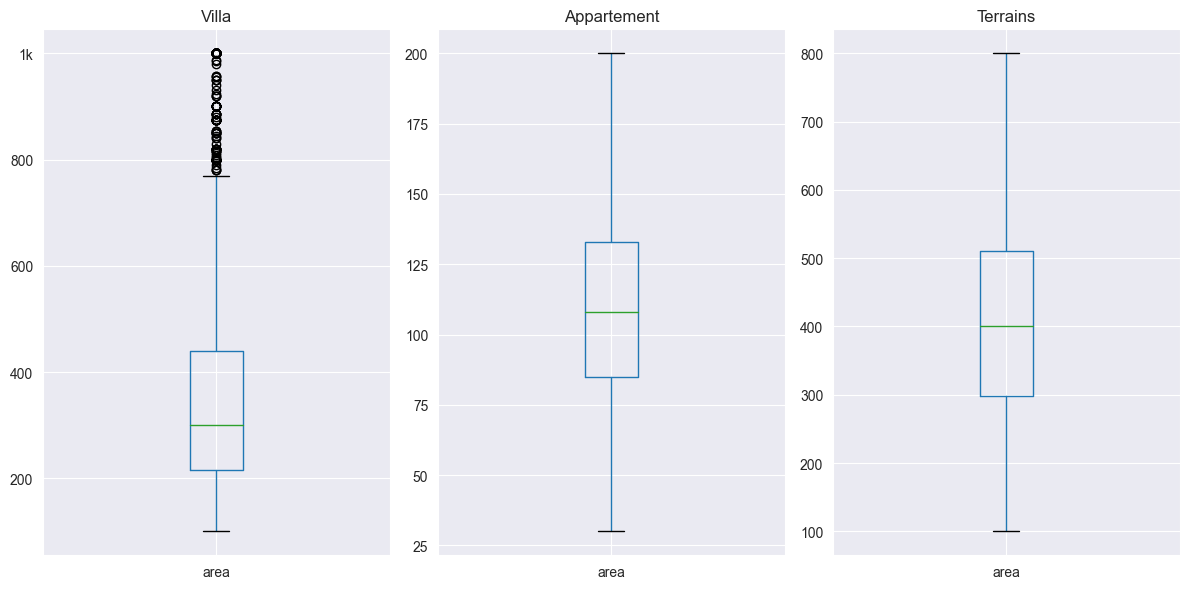

In [18]:
from matplotlib.ticker import FuncFormatter #for number formatting on the graph
def y_formatter(x, pos):
    if x >= 1000:
        return f'{int(x / 1000)}k'
    return str(int(x))

fig, axes = plt.subplots(1, 3, figsize=(12, 6))
agg[agg['Type'] == 'villa'].boxplot(column='area', ax=axes[0],vert=True)
agg[agg['Type'] == 'appartement'].boxplot(column='area', ax=axes[1],vert=True)
agg[agg['Type'] == 'terrain'].boxplot(column='area', ax=axes[2],vert=True)
axes[0].set_title('Villa')
axes[1].set_title('Appartement')
axes[2].set_title('Terrains')

for ax in axes:
    ax.yaxis.set_major_formatter(FuncFormatter(y_formatter))
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Terrain area distribution')

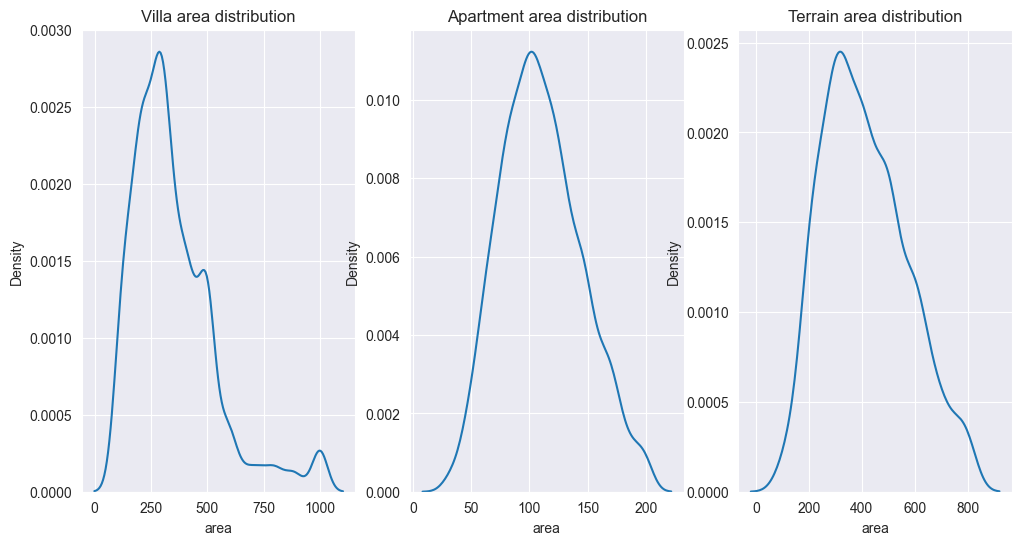

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(12, 6))
sns.kdeplot(agg[agg['Type'] == 'villa']['area'], ax=axes[0])
sns.kdeplot(agg[agg['Type'] == 'appartement']['area'], ax=axes[1])
sns.kdeplot(agg[agg['Type'] == 'terrain']['area'], ax=axes[2])

axes[0].set_title('Villa area distribution')
axes[1].set_title('Apartment area distribution')
axes[2].set_title('Terrain area distribution')


The area distribution for villas looks to be right skewed with 95% of the data points falling under 750 m².
A transformation may be needed for better representation (or outlier removal later on)

In [20]:
agg.groupby('Type')['n_bedrooms'].describe(percentiles=[0.25,.5,.75,.9,.95]).T

Type,appartement,terrain,villa
count,2531.0,1039.0,5121.0
mean,2.450415,0.0,4.010545
std,3.514089,0.0,1.578384
min,0.0,0.0,0.0
25%,2.0,0.0,3.0
50%,2.0,0.0,4.0
75%,3.0,0.0,4.0
90%,3.0,0.0,6.0
95%,4.0,0.0,7.0
max,152.0,0.0,19.0


We set 1 as a lower bound for number of bedrooms and 4 for appartments / 7 for villas (to avoid severe outliers)

In [21]:
agg = agg[
    ((agg['Type'] == 'appartement') & (agg['n_bedrooms'] >= 1) & (agg['n_bedrooms'] <= 4)) |
    ((agg['Type'] == 'villa') & (agg['n_bedrooms'] >= 1)&(agg['n_bedrooms'] <= 7)) | (agg['Type'] == 'terrain')
]

In [22]:
agg.groupby('Type')['n_bathrooms'].describe(percentiles=[0.25,.5,.75,.9,.95]).T


Type,appartement,terrain,villa
count,2251.0,1039.0,4789.0
mean,1.268325,0.0,2.465024
std,0.539107,0.0,1.086619
min,1.0,0.0,1.0
25%,1.0,0.0,2.0
50%,1.0,0.0,2.0
75%,1.0,0.0,3.0
90%,2.0,0.0,4.0
95%,2.0,0.0,4.0
max,11.0,0.0,6.0


In [23]:
agg = agg[
    ((agg['Type'] == 'appartement') & (agg['n_bathrooms'] >= 1) & (agg['n_bathrooms'] <= 2)) |
    ((agg['Type'] == 'villa') & (agg['n_bathrooms'] >= 1)&(agg['n_bathrooms'] <= 5))| (agg['Type'] == 'terrain')
]

According to the following boxplot, outliers exist on the individual state level. We will try to remove outliers.

In [24]:
agg['state'] = agg['state'].apply(lambda x : 'nabeul' if 'hammamet' in x else x)

In [25]:
THRESHOLD = 25
#TODO: TRY UNDERSAMPLING NABEUL
agg = agg[agg['Type'] != 'terrain']

top_20_states = agg['state'].value_counts().nlargest(20).index
filtered_df = agg[agg['state'].isin(top_20_states)]


In [26]:
def process_categorical_column(df, category_column, group_columns='Type',threshold=20,escape=None):
    df = df.copy()
    def process_group(group):
        category_counts = group[category_column].value_counts()
        category_mapping = {}
        for category, count in category_counts.items():
            if count > threshold:
                category_mapping[category] = category
            else:

                category_mapping[category] = escape


        processed_group = group[group[category_column].map(category_mapping).notnull()]
        processed_group[category_column] = processed_group[category_column].map(category_mapping)

        return processed_group

    result = df.groupby(group_columns).apply(process_group).reset_index(drop=True)

    return result

result_state = process_categorical_column(filtered_df, 'state', threshold=THRESHOLD, escape=None)
filtered_df = process_categorical_column(result_state, 'city', group_columns=['Type','state'], threshold=THRESHOLD)   #TODO: EXPERIMENT WITH DIS SHIET

#TODO: GROUP SIMILAR STATES TOGETHER





In [27]:
filtered_df[['state','city']].drop_duplicates()

,state,city
0,ariana,ariana ville
1,ariana,la soukra
2,ariana,ennasr
3,ariana,menzah
225,ben arous,rades
228,ben arous,el mourouj
235,ben arous,medina jedida
328,mahdia,mahdia
390,nabeul,nabeul
392,nabeul,kelibia


In [28]:
#make splits now to avoid data leakage
train_set, test_set = train_test_split(filtered_df, test_size=0.2, random_state=42)

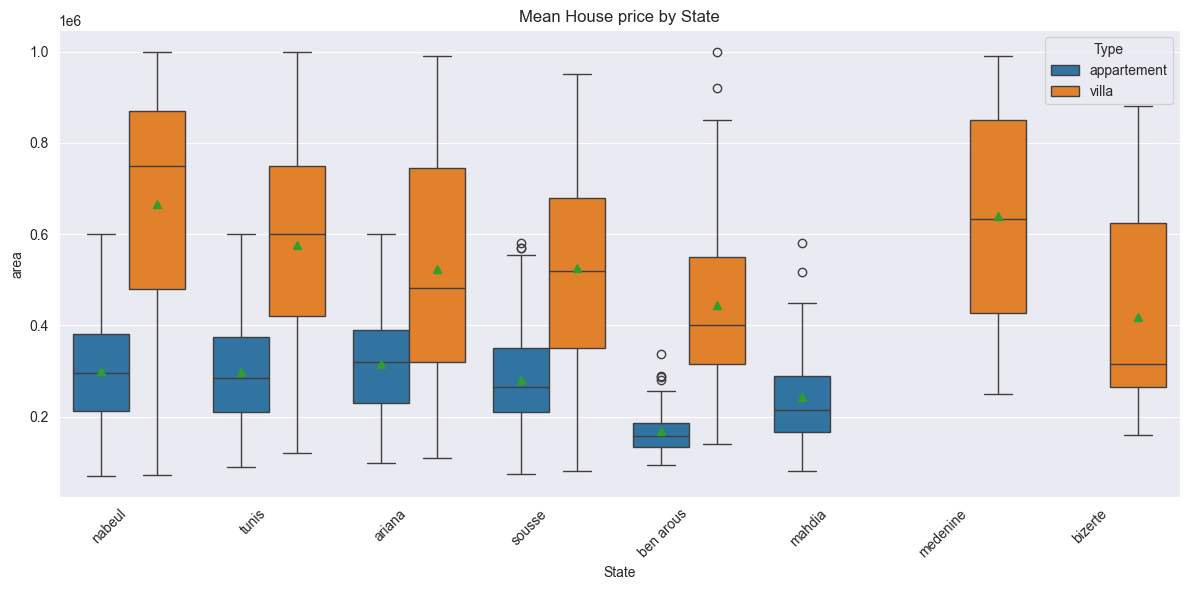

In [29]:

plt.figure(figsize=(12, 6))
sns.boxplot(x=train_set['state'], y=train_set['price'],showmeans=True,hue = train_set['Type'])
plt.xticks(rotation=45, ha='right')
plt.title('Mean House price by State')
plt.ylabel('area')
plt.xlabel('State')
plt.tight_layout()
plt.show()

#TODO: REMOVE OUTLIERS RIGHT AFTER CATEGORICAL


In [30]:

pd.DataFrame(train_set.groupby(['state','Type'])['city'].value_counts())

count
state     Type        city                  
ariana    appartement ennasr              72
                      la soukra           58
                      menzah              23
                      ariana ville        20
          villa       raoued              51
                      la soukra           46
                      ariana ville        21
ben arous appartement medina jedida       28
                      el mourouj          26
                      rades               22
          villa       el mourouj          35
                      medina jedida       26
                      rades               26
bizerte   villa       bizerte nord        24
mahdia    appartement mahdia              50
medenine  villa       djerba              74
nabeul    appartement hammamet           261
                      mrezga             139
                      kelibia             95
                      hammamet nord       65
                      hammamet sud        57
                      nabeul              36
                      hammamet centre     28
          villa       hammamet sud       934
                      hammamet           897
                      kelibia            247
                      hammamet nord      234
                      el haouaria         87
                      mrezga              68
                      beni khiar          65
                      nabeul              58
                      korba               26
sousse    appartement sahloul             73
                      sousse jawhara      57
                      sousse medina       43
                      kantaoui            40
                      hammam sousse       38
                      akouda              27
          villa       sousse jawhara      50
                      hammam sousse       38
                      sahloul             30
                      akouda              24
tunis     appartement l'aouina            57
                      la marsa            38
                      aïn zaghouan        34
                      le bardo            24
          villa       le bardo            35
                      la marsa            34

In [31]:
import pandas as pd


def remove_outliers(df, target_column, group_by, threshold=1.5): #TODO: threshold to be tweaked
    def detect_outliers(group):
        median = group[target_column].median()
        q1 = group[target_column].quantile(0.25)
        q3 = group[target_column].quantile(0.75)
        iqr = q3 - q1
        outliers = (group[target_column] < (median - threshold * iqr)) | (group[target_column] > (median + threshold * iqr))
        return outliers
    outlier_mask = df.groupby(group_by).apply(detect_outliers)
    outlier_mask = outlier_mask.reset_index(level=group_by, drop=True)
    num_outliers = outlier_mask.sum()
    print(f"Found {num_outliers} outliers in the '{target_column}' column.")

    return df[~outlier_mask]

train_set_outliers = remove_outliers(train_set, 'price', group_by=['state', 'Type'])
HAXOR = remove_outliers(train_set, 'price', group_by=['Type','state','city'])

HAXOR['state_city'] = HAXOR['state'] + '_' + HAXOR['city']

Found 192 outliers in the 'price' column.
Found 349 outliers in the 'price' column.


In [32]:
def prepare_test_set(train_df, test_df, group_column, category_column, threshold=15,escape=None):
    test_df = test_df.copy()
    def apply_mapping(test_df, category_mapping, category_column):
        processed_test_df = test_df.copy()
        processed_test_df[category_column] = processed_test_df[category_column].map(
            lambda x: category_mapping.get(x, x)
        )

        return processed_test_df

    def get_category_mapping(train_df, category_column, threshold,escape=None):

        category_counts = train_df[category_column].value_counts()
        category_mapping = {}
        for category, count in category_counts.items():
            if count > threshold:
                category_mapping[category] = category
            else:

                category_mapping[category] = escape

        return category_mapping



    category_mapping = get_category_mapping(train_df, category_column,threshold)
    processed_test_df = apply_mapping(test_df, category_mapping, category_column)

    return processed_test_df


test_set = prepare_test_set(HAXOR, test_set, 'Type', 'state',threshold=THRESHOLD,escape=None)
test_set = prepare_test_set(HAXOR, test_set, 'Type', 'city',threshold=THRESHOLD,escape=None)
test_set['state_city'] = test_set['state'] + '_' + test_set['city']

In [33]:
import category_encoders as ce
from sklearn.preprocessing import LabelEncoder

def prepare_encoders(train_df,columns = 'state_city'):
    target_encoder = ce.TargetEncoder(cols=columns, smoothing=0.1)
    type_encoder = LabelEncoder()
    def fit_target_encoder(group):
        nonlocal target_encoder
        target_encoder.fit(group[columns], group['price'])
        return group
    type_encoder.fit(train_df['Type'])
    train_df.groupby('Type').apply(fit_target_encoder)

    return target_encoder, type_encoder

def encode_dataframe(df, target_encoder, type_encoder, encode_type=True):
    encoded_df = df.copy()
    if encode_type:
        encoded_df['Type_encoded'] = type_encoder.transform(encoded_df['Type'])
    def encode_group(group):

        encoded_group = target_encoder.transform(group['state_city'])
        group['state_city_encoded'] = encoded_group['state_city']
        #group['state_encoded'] = encoded_group['state']
        #group['city_encoded'] = encoded_group['city']
        return group
    encoded_df = encoded_df.groupby('Type').apply(encode_group).reset_index(drop=True)

    return encoded_df

target_encoder, type_encoder = prepare_encoders(HAXOR)
train_df_encoded = encode_dataframe(HAXOR, target_encoder, type_encoder)
test_df_encoded = encode_dataframe(test_set, target_encoder, type_encoder)

In [34]:
# from imblearn.over_sampling import ADASYN
# from imblearn.combine import SMOTETomek
# 
# 
# def prepare_resampling(x, y, method='smotetomek'):
#     class_counts = y.value_counts().to_dict()
#     print(class_counts)
#     majority_class_count = max(class_counts.values())
#     print(list(enumerate(class_counts)))
#     sampling_strategy = {
#         count: min(majority_class_count, class_counts[count] + int(0.01 * (majority_class_count - class_counts[count])) )
#                 for cls, count in enumerate(class_counts)
#     }
#     print(sampling_strategy)
# 
#     if method == 'adasyn':
#         resampler = ADASYN(random_state=130,sampling_strategy=sampling_strategy)
#     elif method == 'smotetomek':
#         resampler = SMOTETomek(random_state=130)
#     X_resampled, y_resampled = resampler.fit_resample(x, y)
#     X_resampled = pd.DataFrame(X_resampled, columns=x.columns)
#     y_resampled = pd.Series(y_resampled, name=y.name)
# 
#     return X_resampled, y_resampled
# def prepare_data(df, target_column, resample_method='smotetomek'):
#     x = df[['n_bedrooms','n_bathrooms','area','price','Type_encoded','state_city_encoded']]
#     y = df[target_column]
# 
#     X_train_resampled, y_train_resampled = prepare_resampling(
#         x, y, method=resample_method
#     )
# 
#     return pd.concat([X_train_resampled,y_train_resampled],axis=1)
# 
# 
# train_set_resampled = prepare_data(
#      df=train_df_encoded,
#      target_column='state_city',
#      resample_method='smotetomek'
#  )


In [38]:
!pip install scikit-learn==0.23.2 --force-reinstall

     ---------------------------------------- 0.0/7.2 MB ? eta -:--:--
     - -------------------------------------- 0.3/7.2 MB ? eta -:--:--
     ---- ----------------------------------- 0.8/7.2 MB 2.1 MB/s eta 0:00:04
     ------- -------------------------------- 1.3/7.2 MB 2.2 MB/s eta 0:00:03
     ---------- ----------------------------- 1.8/7.2 MB 2.1 MB/s eta 0:00:03
     ----------- ---------------------------- 2.1/7.2 MB 2.2 MB/s eta 0:00:03
     -------------- ------------------------- 2.6/7.2 MB 2.2 MB/s eta 0:00:03
     ----------------- ---------------------- 3.1/7.2 MB 2.2 MB/s eta 0:00:02
     -------------------- ------------------- 3.7/7.2 MB 2.2 MB/s eta 0:00:02
     --------------------- ------------------ 3.9/7.2 MB 2.2 MB/s eta 0:00:02
     ------------------------ --------------- 4.5/7.2 MB 2.2 MB/s eta 0:00:02
     --------------------------- ------------ 5.0/7.2 MB 2.2 MB/s eta 0:00:02
     ----------------------------- ---------- 5.2/7.2 MB 2.1 MB/s eta 0:00:01


  error: subprocess-exited-with-error
  
  pip subprocess to install build dependencies did not run successfully.
  exit code: 1
  
  [217 lines of output]
  Ignoring numpy: markers 'python_version == "3.6" and platform_system != "AIX" and platform_python_implementation == "CPython"' don't match your environment
  Ignoring numpy: markers 'python_version == "3.6" and platform_system != "AIX" and platform_python_implementation != "CPython"' don't match your environment
  Ignoring numpy: markers 'python_version == "3.7" and platform_system != "AIX"' don't match your environment
  Ignoring numpy: markers 'python_version == "3.6" and platform_system == "AIX"' don't match your environment
  Ignoring numpy: markers 'python_version == "3.7" and platform_system == "AIX"' don't match your environment
  Ignoring numpy: markers 'python_version >= "3.8" and platform_system == "AIX"' don't match your environment
    Using cached Cython-3.0.11-cp311-cp311-win_amd64.whl.metadata (3.2 kB)
       ------

In [36]:
from pycaret.regression import *
s = setup(HAXOR[['area', 'n_bedrooms', 'n_bathrooms','price','Type','state','city']], target = 'price',
           session_id = 123,categorical_features=['Type','state','city'])
best = compare_models()

AttributeError: 'Series' object has no attribute 'iteritems'

In [ ]:
plot_model(best, plot = 'residuals')

In [135]:
x = predict_model(best,data=test_df_encoded)


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,82745.5329,15312158324.9022,123742.3061,0.8120,0.3246,0.2551


In [136]:
test_df_encoded

,n_bedrooms,n_bathrooms,area,price,title,Type,city,state,state_city,Type_encoded,state_city_encoded
0,3.0,1.0,97.0,240000.0,Appartement S+2 tout neuf à vendre à Mrezga 51...,appartement,mrezga,nabeul,nabeul_mrezga,0,599325.882353
1,3.0,1.0,85.0,200000.0,appartement proche clinique violette,appartement,hammamet,nabeul,nabeul_hammamet,0,776192.780518
2,2.0,1.0,85.0,220000.0,A VENDRE S+2 – AOUINA – TEL 52156061 – FB.5311,appartement,l'aouina,tunis,tunis_l'aouina,0,668523.405188
3,1.0,1.0,75.0,195000.0,Avendre 2 appartement tré haut standing a ham...,appartement,sousse jawhara,sousse,sousse_sousse jawhara,0,514640.0
4,2.0,1.0,92.0,350000.0,Appartement Arès\t(Réf: V970),appartement,hammamet,nabeul,nabeul_hammamet,0,776192.780518
...,...,...,...,...,...,...,...,...,...,...,...
1131,5.0,4.0,800.0,760000.0,V371 Villa Warda WARDA HAMMAMET SUD,villa,hammamet sud,nabeul,nabeul_hammamet sud,1,792991.706161
1132,3.0,1.0,156.0,500000.0,Marsa Erriadh Duplex,villa,la marsa,tunis,tunis_la marsa,1,658529.411765
1133,5.0,3.0,400.0,800000.0,V421 Villa TIA BELLE VILLA,villa,hammamet sud,nabeul,nabeul_hammamet sud,1,792991.706161
1134,5.0,3.0,1000.0,800000.0,A VENDRE #Villa Prés #Salle des Fêtes Sghaier ...,villa,akouda,sousse,sousse_akouda,1,597475.0


In [141]:
dictionary = {'area':130,'n_bedrooms':3,'n_bathrooms':1,'Type':'villa','state':'nabeul','city':'mrezga'}
props = pd.DataFrame(dictionary,index=[0])

In [142]:
props = prepare_test_set(HAXOR, props, 'Type', 'state',threshold=THRESHOLD,escape=None)
props = prepare_test_set(HAXOR, props, 'Type', 'city',threshold=THRESHOLD,escape=None)

In [143]:
props['state_city'] = props['state'] + '_' + props['city']
props_encoded = encode_dataframe(props, target_encoder, type_encoder)


In [144]:
predict_model(best,data=props_encoded)

,area,n_bedrooms,n_bathrooms,Type,state,city,state_city,Type_encoded,state_city_encoded,prediction_label
0,130,3,1,villa,nabeul,mrezga,nabeul_mrezga,1,599325.882353,366801.310447
